## Import the library

In [54]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [55]:
import os
import pandas as pd
from PIL import Image

# Dataloading for Diabetic Retinopathy Image Classification

In [56]:
path = "Dataset\FullDataset\a. DRAC2022_ Diabetic Retinopathy Grading_Training Labels.csv"
df = pd.read_csv(path)

In [57]:
class DiabeticRetinopathyDataset(Dataset):
    def __init__(self, label_df, img_dir, transform=None):
        self.img_labels = label_df
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

In [58]:
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomRotation(30),              # Random rotation within 30 degrees
    transforms.RandomHorizontalFlip(),         # Random horizontal flip
    transforms.RandomVerticalFlip(),           # Random vertical flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Assuming single-channel grayscale images
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Assuming single-channel grayscale images
])

## Load the dataset into the dataloader

In [59]:
# Split the data into training and validation sets while maintaining class balance
train_data = []
val_data = []
for class_label in df['DR grade'].unique():
    class_data = df[df['DR grade'] == class_label]
    train_group, val_group = train_test_split(class_data, test_size=0.2, random_state=101)
    train_data.append(train_group)
    val_data.append(val_group)

train_df = pd.concat(train_data)
val_df = pd.concat(val_data)

In [60]:
# Count the number of images per class
class_counts = train_df['DR grade'].value_counts()

# Print the counts for each class
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} images")

Class 0: 263 images
Class 1: 169 images
Class 2: 56 images


In [61]:
# Count the number of images per class
class_counts = val_df['DR grade'].value_counts()

# Print the counts for each class
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} images")

Class 0: 66 images
Class 1: 43 images
Class 2: 14 images


### Add the class weight to train the model

In [62]:
# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y = val_df['DR grade']
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = torch.tensor(class_weights).type(torch.float32)

In [63]:
class_weights

tensor([0.6212, 0.9535, 2.9286])

In [64]:
img_dir = "Dataset\FullDataset\\a. Training Set"
training_data = DiabeticRetinopathyDataset(train_df, img_dir, train_transform)
validation_data = DiabeticRetinopathyDataset(val_df, img_dir, val_transform)

train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(validation_data, batch_size=32, shuffle=False)

# Modifiying the ResNet Model

In [79]:
import torch.nn as nn
from torchvision.models import (
    resnet18,
    resnet34,
    resnet50,
    resnet101,
    resnet152,
    ResNet18_Weights,
    ResNet34_Weights,
    ResNet50_Weights,
    ResNet101_Weights,
    ResNet152_Weights
)

class DiabeticRetinopathyModel(nn.Module):
    def __init__(self, num_classes=3):
        super(DiabeticRetinopathyModel, self).__init__()
        # Load pre-trained ResNet model
        self.resnet = resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)

        # Modify the last fully connected layer to have num_classes output classes
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

        # Freeze all layers except the last convolutional layer
        for name, param in self.resnet.named_parameters():
            if 'layer4' not in name:  # Assuming 'layer4' is the last convolutional layer
                param.requires_grad = False
        self.resnet.fc.requires_grad = True  # Ensure the classifier's parameters are trainable

    def forward(self, x):
        return self.resnet(x)

# Example usage:
# Instantiate the model
model = DiabeticRetinopathyModel(num_classes=3)


## Training the dataset

In [80]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [81]:
criterion = nn.CrossEntropyLoss()#weight=class_weights.to(device))

# Define your optimizer
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# Define your scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Decrease LR by a factor of 0.1 every 10 epochs

# Define lists to store losses and accuracies
train_losses = []
train_accuracies = []
val_accuracies = []
current_accuracy = 0
train_accuracy = 0

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.to(device)
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_dataloader)
    epoch_acc = correct / total

    # Save losses and accuracies for plotting
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    #validation loop
    model.eval()  # Set the model to evaluation mode

    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Update statistics
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_epoch_acc = val_correct / val_total
    # Save accuracies for plotting
    val_accuracies.append(val_epoch_acc)

    if val_epoch_acc > current_accuracy:
        current_accuracy = val_epoch_acc
        torch.save(model, 'def_resnet152val.pth')
    if epoch_acc > train_accuracy:
        train_accuracy = epoch_acc
        torch.save(model, 'def_resnet152train.pth')
    
    
    # Step the scheduler
    scheduler.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Acc:{val_epoch_acc:.4f}")


Epoch 1/100: Train Loss: 0.9661, Train Acc: 0.5225, Val Acc:0.5691
Epoch 2/100: Train Loss: 0.7758, Train Acc: 0.6660, Val Acc:0.3740
Epoch 3/100: Train Loss: 0.6671, Train Acc: 0.7459, Val Acc:0.5366
Epoch 4/100: Train Loss: 0.6360, Train Acc: 0.7172, Val Acc:0.6911
Epoch 5/100: Train Loss: 0.5768, Train Acc: 0.7910, Val Acc:0.6504
Epoch 6/100: Train Loss: 0.6484, Train Acc: 0.7766, Val Acc:0.7317
Epoch 7/100: Train Loss: 0.4959, Train Acc: 0.8217, Val Acc:0.7480
Epoch 8/100: Train Loss: 0.4705, Train Acc: 0.8094, Val Acc:0.7805
Epoch 9/100: Train Loss: 0.4714, Train Acc: 0.8094, Val Acc:0.7967
Epoch 10/100: Train Loss: 0.4256, Train Acc: 0.8115, Val Acc:0.7561
Epoch 11/100: Train Loss: 0.3975, Train Acc: 0.8463, Val Acc:0.7480
Epoch 12/100: Train Loss: 0.4020, Train Acc: 0.8320, Val Acc:0.7561
Epoch 13/100: Train Loss: 0.3599, Train Acc: 0.8586, Val Acc:0.7805
Epoch 14/100: Train Loss: 0.3622, Train Acc: 0.8545, Val Acc:0.7642
Epoch 15/100: Train Loss: 0.3548, Train Acc: 0.8627, Val 

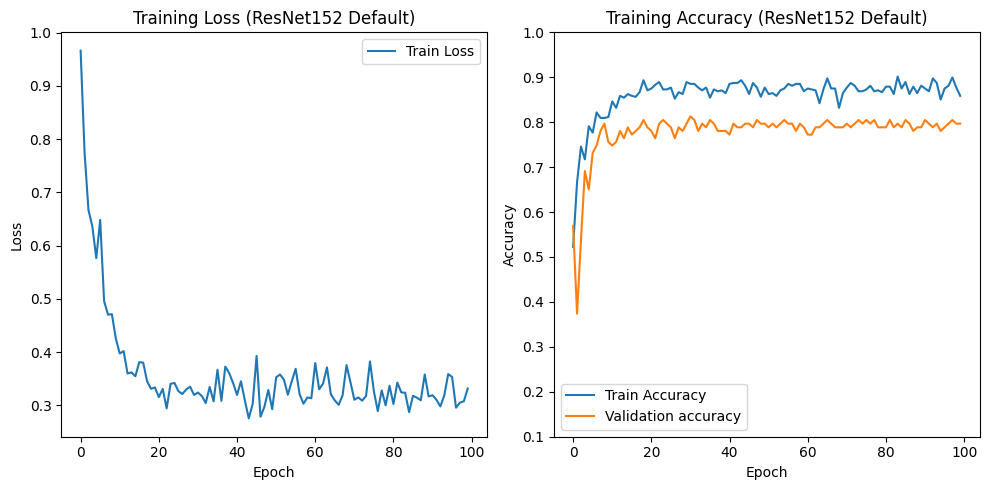

In [82]:
# Plot loss and accuracy graphs
model_name = "ResNet152 Default"
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training Loss ({model_name})')  # Include model name in the title
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label = 'Validation accuracy')
plt.ylim(0.1, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Training Accuracy ({model_name})')  # Include model name in the title
plt.legend()


plt.tight_layout()
plt.show()

## Validate the model

In [88]:
import torch
from sklearn.metrics import precision_score, recall_score, confusion_matrix

model = torch.load("def_resnet152val.pth")
model.eval()  # Set the model to evaluation mode

val_loss = 0.0
val_correct = 0
val_total = 0

# Initialize variables for precision, recall, and confusion matrix
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_dataloader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Update statistics
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

        # Collect true and predicted labels for calculating metrics
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

In [89]:
# Calculate average validation loss and accuracy
val_epoch_loss = val_loss / len(val_dataloader)
val_epoch_acc = val_correct / val_total

# Calculate accuracy, precision, recall, and confusion matrix
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_acc:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Validation Loss: 0.5725, Validation Accuracy: 0.8130
Precision: 0.8170, Recall: 0.8130
Confusion Matrix:
[[60  6  0]
 [ 9 33  1]
 [ 0  7  7]]


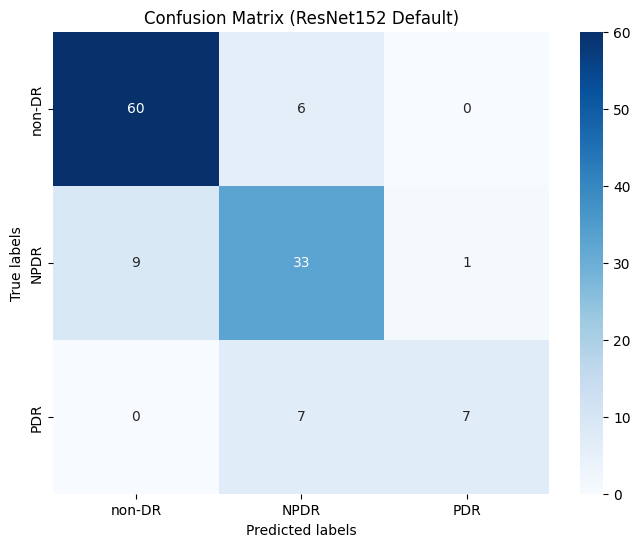

In [90]:
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['non-DR', 'NPDR', 'PDR'], 
            yticklabels=['non-DR', 'NPDR', 'PDR'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix ({model_name})')
plt.show()

## Inferencing the model with the test datast

In [91]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image


test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Assuming single-channel grayscale images
])

class DiabeticRetinopathyTestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_list = os.listdir(img_dir)
    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        img_filename = self.img_list[idx]
        img_path = os.path.join(self.img_dir, img_filename)
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, img_filename  # Returning image and filename
    
img_dir = "Dataset\FullDataset\\b. Testing Set"
test_data = DiabeticRetinopathyTestDataset(img_dir, train_transform)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)

model = torch.load("def_resnet152val.pth")
model.eval()  # Set the model to evaluation mode

results = []
for images, img_filenames in test_dataloader:
    images = images.to(device)
    
    # Forward pass
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    probabilities = probabilities.cpu().detach().numpy().squeeze()
    
    img_filename = img_filenames[0]  # Extract the filename from the tuple
    results.append([img_filename, predicted.item()] + probabilities.tolist())

In [ ]:
import re
# Convert results to a DataFrame
columns = ['case', 'class', 'P0', 'P1', 'P2']
df = pd.DataFrame(results, columns=columns)

# Extract numerical part from "case" column while keeping the file extension intact
df['numeric_case'] = df['case'].apply(lambda x: int(re.search(r'\d+', x).group()))

# Sort DataFrame by the numerical "case" column
df_sorted = df.sort_values(by='numeric_case', ascending=True)

# Drop the 'numeric_case' column
df_sorted.drop(columns=['numeric_case'], inplace=True)

# Save sorted DataFrame to CSV
df_sorted.to_csv('resnet152val_sorted.csv', index=False)